Download dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#install kaggle dependency
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

100% 1.68G/1.68G [01:24<00:00, 23.4MB/s]
100% 1.68G/1.68G [01:24<00:00, 21.3MB/s]


In [ ]:
#extract file
import zipfile

with zipfile.ZipFile('deepfake-and-real-images.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [ ]:
# import shutil

# folder_path = '/content/FaceForensics'
# try:
#     shutil.rmtree(folder_path)
#     print(f"Folder '{folder_path}' and its contents have been removed.")
# except Exception as e:
#     print(f"An error occurred: {e}")


In [ ]:
# import cv2
# image = cv2.imread("/content/dataset/DATASET/test/fake/10004.jpg")
# print(image.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import os

Preprocess Input

In [ ]:
# Define your data preparation functions
class_mapping = {
    "Fake":0,
    "Real":1
}
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = preprocess_input(np.array(img).astype(np.float32))
    return img

def load_data(data_dir, amount):
    x_data = []
    y_data = []
    count = 0
    for class_folder in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_folder)
        class_label = class_mapping.get(class_folder, -1)
        for image_file in os.listdir(class_path):
            if image_file.endswith(('.jpg', '.jpeg', '.png')) and count < amount:
                count += 1
                img = preprocess_image(os.path.join(class_path, image_file))
                x_data.append(img)
                y_data.append(class_label)
        count = 0
    return x_data,y_data

Model

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
output = base_model.output
output = tf.keras.layers.GlobalAveragePooling2D()(output)
output = tf.keras.layers.Dense(256, activation='relu')(output)
output = tf.keras.layers.Dense(2, activation='softmax')(output)

for layer in base_model.layers:
    layer.trainable = False

model = Model(inputs=base_model.input, outputs=output)

16705208/16705208 [==============================] - 1s 0us/step


Augment

In [ ]:
import random
def Rotate(img,min_angle,max_angle):
    angle = random.uniform(min_angle, max_angle)
    # Get the image dimensions
    height, width = image.shape[:2]
    # Calculate the rotation matrix
    center = (width / 2, height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Perform the rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)
    return rotated_image
def Flip(img):
  if random.randint(0,1):
    return cv2.flip(img,1)
  return cv2.flip(img,0)
def Blur(img,kernel_size=(5,5),sigma_x=0):
  return cv2.GaussianBlur(img, kernel_size, sigma_x)
def add_noise(img,noise_mean=0,noise_std=0.5,noise_factor=0.5):
  img_noise = img + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=img.shape))
  return img_noise

In [ ]:
# Load and split your data
x_train, y_train = load_data("/content/dataset/Dataset/Train", 1000)

In [ ]:
for i in range(500,1500):
  x = random.randint(0,4)
  image = x_train[i]
  if x == 0 :
    image = Rotate(image,-30,30)
  elif x == 1 :
    image = Flip(image)
  elif x == 2 :
    image = Blur(image)
  else :
    image = add_noise(image)
  x_train.append(image)
  y_train.append(y_train[i])

In [ ]:
print(len(x_train),len(y_train))

5000 5000


In [ ]:
x_test, y_test = load_data("/content/dataset/Dataset/Test", 500)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = x_train.reshape(x_train.shape[0], 224, 224, 3)
x_test = x_test.reshape(x_test.shape[0],224,224, 3)

In [ ]:
num_samples = len(x_train)
shuffled_indices = np.arange(num_samples)
np.random.shuffle(shuffled_indices)
x_train = np.take(x_train, shuffled_indices, axis=0)
y_train = np.take(y_train, shuffled_indices, axis=0)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [ ]:
# Prepare labels
y_train_encoded = tf.keras.utils.to_categorical(y_train, 2)
y_val_encoded = tf.keras.utils.to_categorical(y_val, 2)
print(len(y_train_encoded),len(y_val_encoded))

2100 900


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 167, 167, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 167, 167, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 167, 167, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 167, 167, 3)          0         ['normalization[0][0]']   

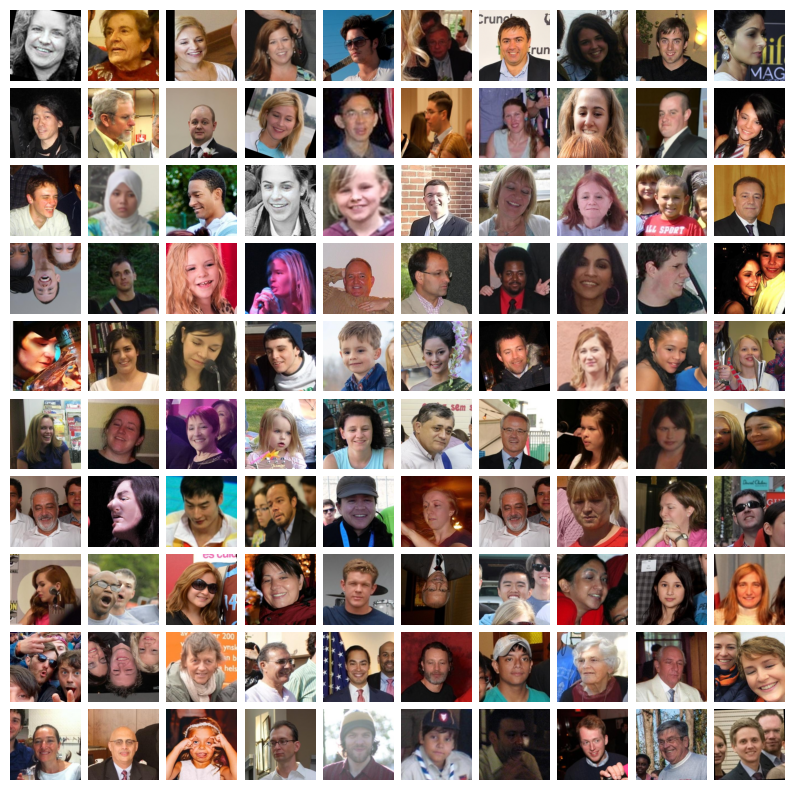

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
        ax.imshow(x_train[2000+i]/255.0)
        ax.axis('off')

# Adjust spacing and display the plot
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

Epoch 1/20
66/66 [==============================] - 30s 198ms/step - loss: 0.5610 - accuracy: 0.7076 - val_loss: 0.5332 - val_accuracy: 0.7156
Epoch 2/20
66/66 [==============================] - 7s 109ms/step - loss: 0.4285 - accuracy: 0.8067 - val_loss: 0.4974 - val_accuracy: 0.7778
Epoch 3/20
66/66 [==============================] - 8s 120ms/step - loss: 0.3507 - accuracy: 0.8524 - val_loss: 0.5268 - val_accuracy: 0.7511
Epoch 4/20
66/66 [==============================] - 7s 108ms/step - loss: 0.2830 - accuracy: 0.8890 - val_loss: 0.4765 - val_accuracy: 0.8033
Epoch 5/20
66/66 [==============================] - 6s 98ms/step - loss: 0.2325 - accuracy: 0.9114 - val_loss: 0.4924 - val_accuracy: 0.7911
Epoch 6/20
66/66 [==============================] - 6s 97ms/step - loss: 0.1893 - accuracy: 0.9381 - val_loss: 0.4986 - val_accuracy: 0.8056
Epoch 7/20
66/66 [==============================] - 7s 111ms/step - loss: 0.1556 - accuracy: 0.9490 - val_loss: 0.4934 - val_accuracy: 0.8067
Epoch 8

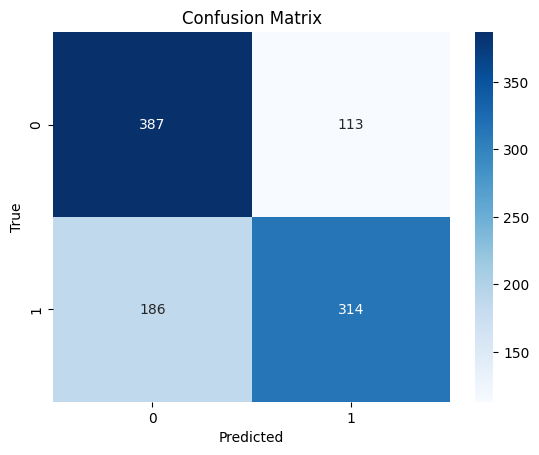

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train_encoded, validation_data=(x_val, y_val_encoded), epochs=20, batch_size=32)

# Evaluate the model and create a confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_encoded = tf.keras.utils.to_categorical(y_test, 2)
cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), y_pred_classes)
classes = unique_labels(np.argmax(y_test_encoded, axis=1), y_pred_classes)

# Create a heatmap for the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()


In [ ]:
model.save("efficientB0.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
predictions = model.predict(x_val)
predicted_labels = np.argmax(predictions, axis=1)
multiclass_labels = np.argmax(y_val_encoded, axis=1)

f1 = f1_score(multiclass_labels , predicted_labels, average='weighted')
recall = recall_score(multiclass_labels , predicted_labels, average='weighted')
precision = precision_score(multiclass_labels , predicted_labels, average='weighted')

report = classification_report(multiclass_labels , predicted_labels)
print(report)

print("Weighted F1-score:", f1)
print("Weighted Recall:", recall)
print("Weighted Precision:", precision)

29/29 [==============================] - 2s 65ms/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       445
           1       0.86      0.84      0.85       455

    accuracy                           0.85       900
   macro avg       0.85      0.85      0.85       900
weighted avg       0.85      0.85      0.85       900

Weighted F1-score: 0.8522238641995581
Weighted Recall: 0.8522222222222222
Weighted Precision: 0.8523959643450566


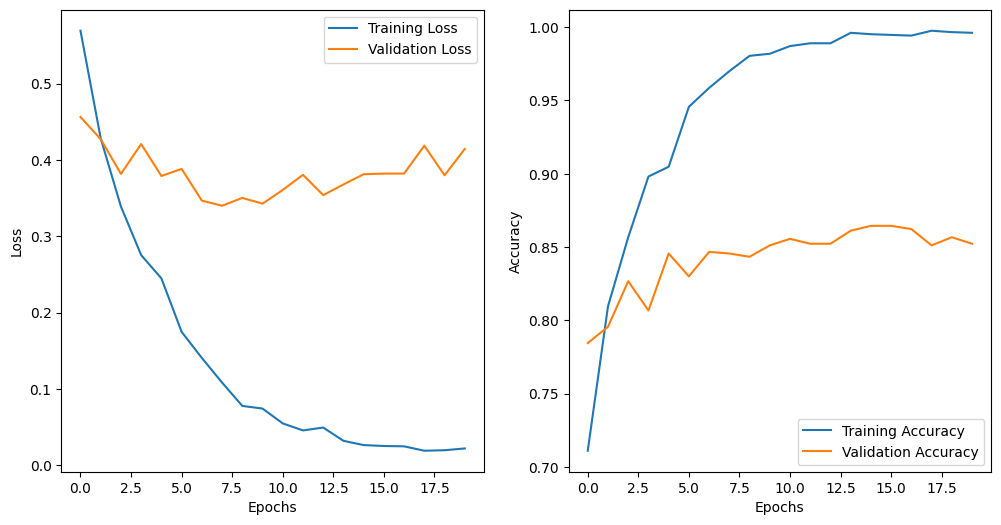

In [ ]:
import matplotlib.pyplot as plt

# Access the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(sns.__version__)

2.14.0
1.23.5
4.8.0
0.12.2


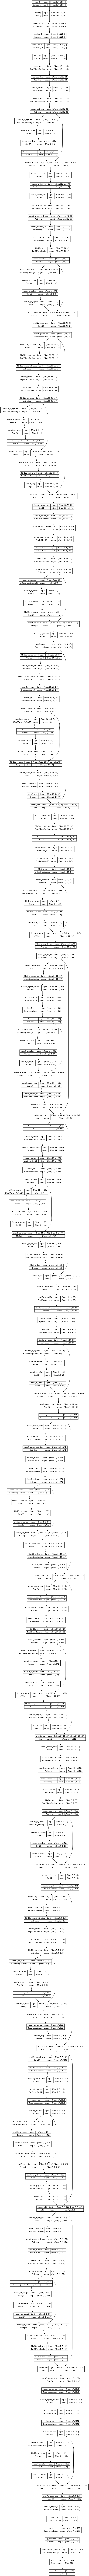

In [ ]:
from tensorflow.keras.utils import plot_model

# Replace 'model' with your actual Keras model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
